In [68]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
train_data = pd.read_csv('train.dat', sep='\s+', header=None)
test_data = pd.read_table('test.dat', sep='\s+', header=None)

# Rename the columns
train_data.columns = ['yr', 'pop']
test_data.columns = ['yr', 'pop']

# Get the data into X_train, y_train, X_test, y_test using iloc
X_train = train_data.iloc[:,0].values.reshape(-1,1)
y_train = train_data.iloc[:,1].values.reshape(-1,1)

X_test = test_data.iloc[:,0].values.reshape(-1,1)
y_test = test_data.iloc[:,1].values.reshape(-1,1)

In [69]:
# Define the range of kF to consider
kf_range = range(2, 7)

# Create empty lists to store the RMSE for each case and the optimal degree and regularization parameter
rmse_list = []
d_star_list = []
lambda_star_list = []
kf_rmse_avg_list = []

# Define the range of d and lambda to search over
param_grid = {'polynomialfeatures__degree': range(1, 12),
              'ridge__alpha': [0,np.exp(-25),np.exp(-20),np.exp(-14),np.exp(-7),np.exp(-3),1,np.exp(3),np.exp(7)]}

# Loop over different kF values
for kF in kf_range:
    # Create a KFold object with the current kF value
    kf = KFold(n_splits=kF, shuffle=True, random_state=42)
    
    # Create an empty list to store the RMSE for the current kF
    kF_rmse_list = []
    
    # Loop over the folds of the current kF
    for train_index, val_index in kf.split(X_train):
        # Split the data into training and validation sets for the current fold
        X_kf_train, X_kf_val = X_train[train_index], X_train[val_index]
        y_kf_train, y_kf_val = y_train[train_index], y_train[val_index]
        
        # Create a pipeline that combines StandardScaler(), PolynomialFeatures() and Ridge() classes
        model = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge(solver='cholesky', fit_intercept=True))

        # Create a GridSearchCV object with the pipeline and the parameter grid
        grid_search = GridSearchCV(model, param_grid, cv=6, scoring='neg_mean_squared_error')

        # Fit the grid search object on the training data
        grid_search.fit(X_kf_train, y_kf_train)

        # Get the best hyperparameters from the grid search object
        best_params = grid_search.best_params_
        d_star = best_params['polynomialfeatures__degree']
        lambda_star = best_params['ridge__alpha']
        # Store the optimal degree and regularization parameter for the current fold
        d_star_list.append(d_star)
        lambda_star_list.append(lambda_star)

        # Create a new pipeline with the optimal hyperparameters
        model = make_pipeline(StandardScaler(), PolynomialFeatures(degree=d_star), Ridge(alpha=lambda_star, solver='cholesky', fit_intercept=True))

        # Fit the new pipeline on the training data
        model.fit(X_kf_train, y_kf_train)

        # Predict the target variable on the validation set
        y_pred = model.predict(X_kf_val)

        # Extract the coefficient weights of the d∗-degree polynomial and the λ∗-regularized 12-degree learned on all the training data
        coefficients = model.named_steps['ridge'].coef_

        # Compute the root mean squared error for the current fold
        kF_rmse_list.append(np.sqrt(mean_squared_error(y_kf_val, y_pred)))

    # Compute the mean RMSE over all folds for the current kF
    mean_rmse = np.mean(kF_rmse_list)

    # Store the mean RMSE for the current kF
    rmse_list.append(mean_rmse)

    # Store the list of RMSEs for the current kF
    kf_rmse_avg_list.append(kF_rmse_list)

In [70]:
#Getting the dataframe for the RMSE for each fold
rmse_kf_df = pd.DataFrame(kf_rmse_avg_list, columns=[f'Fold {i+1}' for i in range(kF)], index=[f'kF={i}' for i in kf_range])
rmse_kf_df

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Fold 6
kF=2,0.102517,0.159869,NaN,NaN,NaN,NaN
kF=3,0.108786,0.600445,0.133727,NaN,NaN,NaN
kF=4,0.094817,0.111373,0.107864,0.160848,NaN,NaN
kF=5,0.078582,0.119294,0.119004,0.110539,0.090943,NaN
kF=6,0.055591,0.127402,0.076575,0.093563,0.152636,0.093907


In [71]:
#get average RMSE for each kF
rmse_kf_df.mean(axis=1)

kF=2    0.131193
kF=3    0.280986
kF=4    0.118725
kF=5    0.103672
kF=6    0.099945
dtype: float64

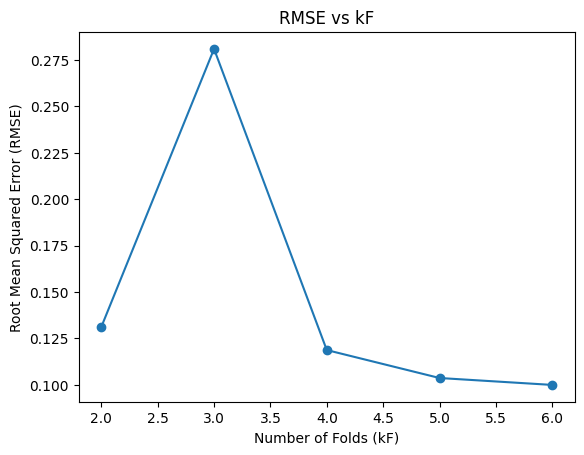

In [72]:
#Plot the rmse average for each kF
plt.plot(kf_range, rmse_kf_df.mean(axis=1), marker='o')
plt.xlabel('Number of Folds (kF)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE vs kF')
plt.show()

In [73]:
d_star_list

[8, 6, 8, 8, 6, 10, 10, 10, 10, 10, 8, 6, 10, 8, 10, 8, 10, 10, 10, 8]

In [74]:
lambda_star_list

[0.0009118819655545162,
 0.049787068367863944,
 0.0009118819655545162,
 0.0009118819655545162,
 0.049787068367863944,
 0.0009118819655545162,
 0.0009118819655545162,
 8.315287191035679e-07,
 0,
 0.0009118819655545162,
 0.0009118819655545162,
 0.0009118819655545162,
 8.315287191035679e-07,
 0.0009118819655545162,
 0.0009118819655545162,
 0.0009118819655545162,
 0.0009118819655545162,
 0.0009118819655545162,
 0.0009118819655545162,
 0.0009118819655545162]

In [75]:
# Compute the index of the minimum mean RMSE
idx_min_rmse = np.argmin(rmse_list)

# Get the optimal degree and regularization parameter from the lists
d_star_opt = d_star_list[idx_min_rmse]
lambda_star_opt = lambda_star_list[idx_min_rmse]

# Print the optimal degree and regularization parameter
print(f"The optimal degree is {d_star_opt} and the optimal regularization parameter is {lambda_star_opt:.2e}")

# Print the coefficient-weights of the d∗-degree polynomial and the λ∗-regularized 12-degree learned on all the training data
print("Coefficients of the d∗-degree polynomial:")
print('coeff:',model.named_steps['ridge'].coef_)

The optimal degree is 6 and the optimal regularization parameter is 4.98e-02
Coefficients of the d∗-degree polynomial:
coeff: [[ 0.          1.41027678  4.28238228 -1.92793174 -4.38398966  0.97135127
   1.32894803 -0.13404705 -0.14013278]]


In [76]:
# Print the coefficient-weights of the d∗-degree polynomial and the λ∗-regularized 12-degree learned on all the training data
print("Coefficients of the λ∗-regularized 12-degree polynomial:")
print('coeff:',model.named_steps['ridge'].coef_)

# Create a new pipeline with the optimal hyperparameters
model = make_pipeline(StandardScaler(), PolynomialFeatures(degree=d_star_opt), Ridge(alpha=lambda_star_opt, solver='cholesky', fit_intercept=True))

# Fit the new pipeline on the training data
model.fit(X_train, y_train)

# Predict the target variable on the test set
y_pred = model.predict(X_test)

# Compute the root mean squared error on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

#compute the root mean squared error on the training set
rmse_train = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))

# Print the root mean squared error on the test set and training set
print(f"The root mean squared error on the training set is {rmse_train:.2f}")
print(f"The root mean squared error on the test set is {rmse_test:.2f}")

Coefficients of the λ∗-regularized 12-degree polynomial:
coeff: [[ 0.          1.41027678  4.28238228 -1.92793174 -4.38398966  0.97135127
   1.32894803 -0.13404705 -0.14013278]]
The root mean squared error on the training set is 0.12
The root mean squared error on the test set is 0.10


In [77]:
#define poly_model with optimal hyperparameters
poly_model = make_pipeline(StandardScaler(), PolynomialFeatures(degree=d_star_opt), Ridge(alpha=lambda_star_opt, solver='cholesky', fit_intercept=True))

#fit the model
poly_model.fit(X_train, y_train)

#predict the target variable on the test set
y_pred = poly_model.predict(X_test)

#compute the root mean squared error on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

#compute the root mean squared error on the training set
rmse_train = np.sqrt(mean_squared_error(y_train, poly_model.predict(X_train)))


#define ridge_model with optimal hyperparameters
ridge_model = make_pipeline(StandardScaler(), Ridge(alpha=lambda_star_opt, solver='cholesky', fit_intercept=True))

#fit the model
ridge_model.fit(X_train, y_train)

#predict the target variable on the test set
y_pred = ridge_model.predict(X_test)

#compute the root mean squared error on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

#compute the root mean squared error on the training set
rmse_train = np.sqrt(mean_squared_error(y_train, ridge_model.predict(X_train)))

In [78]:
# Predict the target variable using the polynomial model for d_star_opt
y_train_pred_d_star = poly_model.predict(X_train)
y_test_pred_d_star = poly_model.predict(X_test)

# Compute the root mean squared error for the d_star_opt polynomial
train_rmse_d_star = np.sqrt(mean_squared_error(y_train, y_train_pred_d_star))
test_rmse_d_star = np.sqrt(mean_squared_error(y_test, y_test_pred_d_star))

# Predict the target variable using the Ridge model for lambda_star_opt
y_train_pred_lambda_star = ridge_model.predict(X_train)
y_test_pred_lambda_star = ridge_model.predict(X_test)

# Compute the root mean squared error for the lambda_star_opt polynomial
train_rmse_lambda_star = np.sqrt(mean_squared_error(y_train, y_train_pred_lambda_star))
test_rmse_lambda_star = np.sqrt(mean_squared_error(y_test, y_test_pred_lambda_star))

In [79]:
#get the training and test RMSE for the lamda* regularization parameter
print(f"The training RMSE for the optimal degree is {train_rmse_d_star:.2f} and the test RMSE is {test_rmse_d_star:.2f}")
print(f"The training RMSE for the optimal regularization parameter is {train_rmse_lambda_star:.2f} and the test RMSE is {test_rmse_lambda_star:.2f}")

The training RMSE for the optimal degree is 0.12 and the test RMSE is 0.10
The training RMSE for the optimal regularization parameter is 1.02 and the test RMSE is 0.96


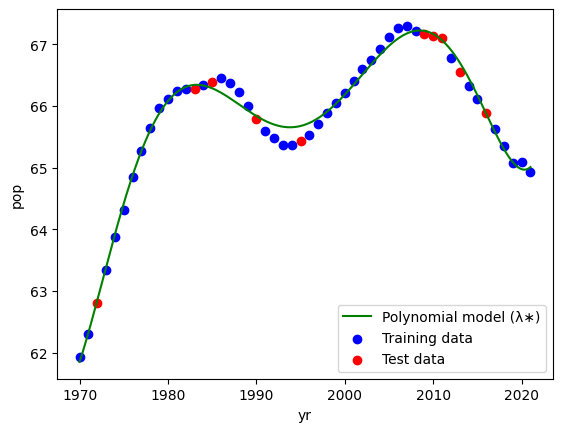

In [80]:
# Plot the polynomial curve for lambda_star
x_range = np.linspace(X_train.min(), X_train.max(), 1000)
y_range_pred_lambda_star = poly_model.predict(x_range.reshape(-1, 1))
plt.plot(x_range, y_range_pred_lambda_star, color='green', label='Polynomial model (λ∗)')

# Plot the training and test data points
plt.scatter(X_train, y_train, color='blue', label='Training data')
plt.scatter(X_test, y_test, color='red', label='Test data')

# Add axis labels and legend
plt.xlabel('yr')
plt.ylabel('pop')
plt.legend()

# Show the plot
plt.show()


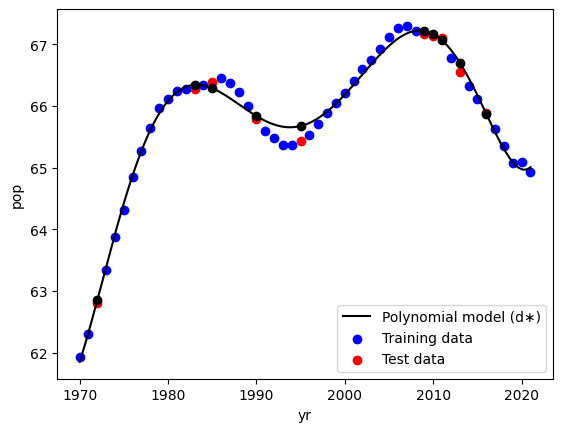

In [81]:
# Plot the polynomial curve for d_star
x_range = np.linspace(X_train.min(), X_train.max(), 1000)
y_range_pred_d_star = poly_model.predict(x_range.reshape(-1, 1))
plt.plot(x_range, y_range_pred_d_star, color='black', label='Polynomial model (d∗)')

# Plot the training and test data points
plt.scatter(X_train, y_train, color='blue', label='Training data')
plt.scatter(X_test, y_test, color='red', label='Test data')
plt.scatter(X_test, y_test_pred_d_star, color='black')

# Add axis labels and legend
plt.xlabel('yr')
plt.ylabel('pop')
plt.legend()

# Show the plot
plt.show()
